# Test model with simple linear regression

In [12]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger 
import tigerpy.bbvi as bbvi

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

rng = np.random.default_rng(42)

## Simulate data

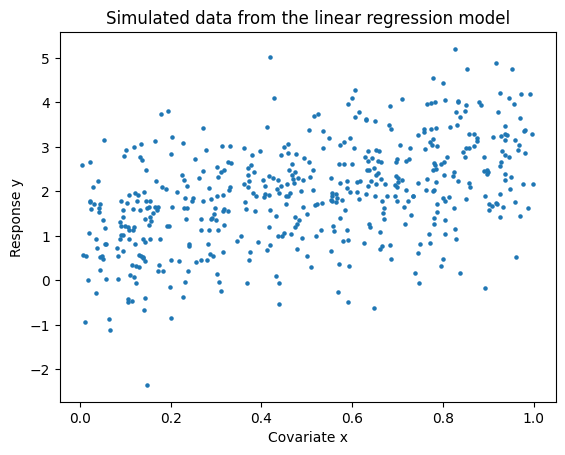

In [13]:
# sample size and true parameters

n = 500
true_beta = np.array([1.0, 2.0])
true_sigma = 1.0

# data-generating process

x0 = rng.uniform(size=n)
X_mat = np.column_stack([np.ones(n), x0])
eps = rng.normal(scale=true_sigma, size=n)
y_vec = X_mat @ true_beta + eps

# plot the simulated data

plt.scatter(x0, y_vec, s = 5)
plt.title("Simulated data from the linear regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [14]:
# set up design matrix 
X = tiger.Obs(name = "X_loc")
X.fixed(X = x0)

# set up hyperparameters
beta_loc = tiger.Hyper(0, name="beta_loc")
beta_scale = tiger.Hyper(100, name="beta_scale")

# set up parameters 
beta_dist = tiger.Dist(tfd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="a")
sigma_b = tiger.Hyper(0.01, name="b")

sigma_dist = tiger.Dist(tfd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, function=jnp.exp, name="sigma")

# set up the linear predictor 
lpred = tiger.Lpred(X=X, name="loc", beta=beta)

# set up response distribution
y_dist = tiger.Dist(tfd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(y=y_vec, distribution=y_dist)

In [15]:
# build the model tree
m.build_tree()

In [16]:
m.log_lik

Array([-3.3007705, -3.240914 , -3.2759068, -3.248854 , -3.2267048,
       -3.2451065, -3.2651124, -3.236326 , -3.2399905, -3.2661066,
       -3.2437449, -3.2544785, -3.2591083, -3.2488282, -3.2613528,
       -3.2222342, -3.2372513, -3.225249 , -3.228254 , -3.2873063,
       -3.2797108, -3.22642  , -3.231876 , -3.2216828, -3.24179  ,
       -3.2940927, -3.2495687, -3.2229178, -3.2372532, -3.224765 ,
       -3.2455525, -3.2675645, -3.2337785, -3.253572 , -3.2476015,
       -3.2424803, -3.2231567, -3.2621143, -3.2690406, -3.230901 ,
       -3.2263908, -3.3015695, -3.2459264, -3.2673845, -3.2462099,
       -3.3041277, -3.2396963, -3.2383578, -3.2987368, -3.225735 ,
       -3.2225757, -3.2231264, -3.2673128, -3.2244418, -3.2679691,
       -3.24198  , -3.2685146, -3.2218535, -3.2227392, -3.22257  ,
       -3.232933 , -3.245501 , -3.2405605, -3.2474387, -3.2437897,
       -3.2482169, -3.2276828, -3.2483141, -3.2363899, -3.2470272,
       -3.2412388, -3.2438576, -3.3339508, -3.2310567, -3.2248

In [17]:
m.log_prior

Array(-18.020359, dtype=float32)

In [18]:
m.log_prob

Array(-1641.4343, dtype=float32)

In [19]:
sample = dict(beta=jnp.array([0,0], dtype=jnp.float32), scale=jnp.array([1], dtype=jnp.float32))

m.update_graph(sample=sample)

Array(-1740.374, dtype=float32)

In [20]:
jnp.sum(m.log_lik)

Array(-1724.6703, dtype=float32)

In [21]:
m.log_prior

Array(-15.703748, dtype=float32)

## Inference with BBVI

In [22]:
key = jax.random.PRNGKey(27)

q = bbvi.Bbvi(Model=m, num_samples=128, num_iterations=5000, seed=key)

In [23]:
q.run_bbvi(step_size=0.01)

(Array(739.5083, dtype=float32),
 {'beta': {'mu': Array([0.98851115, 1.9045088 ], dtype=float32),
   'cov': Array([[ 0.00855202, -0.01224469],
          [-0.01224469,  0.02340376]], dtype=float32)},
  'scale': {'mu': Array([0.01854754], dtype=float32),
   'cov': Array([[0.00120398]], dtype=float32)}})

In [24]:
jnp.sqrt(0.025)

Array(0.15811388, dtype=float32, weak_type=True)

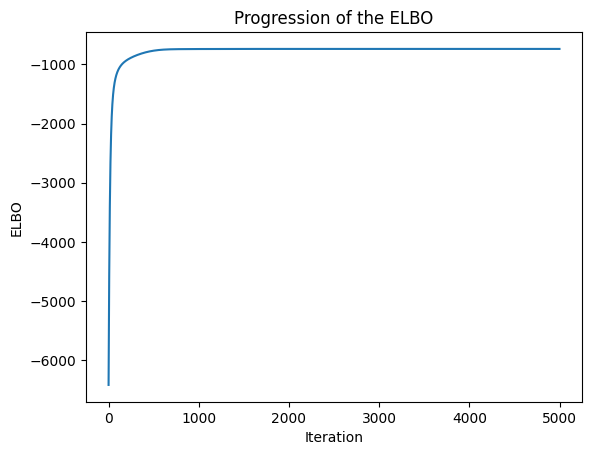

In [25]:
q.plot_elbo()